In [6]:
import keras
import json
import numpy as np
import pandas as pd
import nibabel as nib
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K

import util
from public_tests import *
from test_utils import *

import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [7]:
Data_Dir = "/content/drive/MyDrive/MRI_CVision_Data/imagesTr/"
Labels_Dir = "/content/drive/MyDrive/MRI_CVision_Data/labelsTr/"

def load_case(image_nifty_file, label_nifty_file):
    image = np.array(nib.load(image_nifty_file).get_fdata())
    label = np.array(nib.load(label_nifty_file).get_fdata())
    return image, label

# Patches

In [8]:
# due to limited processing power, "patches" or "sub-volumes" if shape (160, 160, 16) are required
# patches have to be at least 5% tumor


def get_sub_volume(image, label,
                   orig_x = 240, orig_y = 240, orig_z = 155,
                   output_x = 160, output_y = 160, output_z = 16,
                   num_classes = 4, max_tries = 1000,
                   background_threshold=0.95):

    X = None
    y = None
    tries = 0

    while tries < max_tries:
        start_x = np.random.randint(orig_x-output_x+1)
        start_y = np.random.randint(orig_y-output_y+1)
        start_z = np.random.randint(orig_z-output_z+1)

        y = label[start_x: start_x + output_x,
                  start_y: start_y + output_y,
                  start_z: start_z + output_z]
        y = keras.utils.to_categorical(y, num_classes=num_classes)

        bgrd_ratio = np.sum(y[:, :, :, 0])/(output_x * output_y * output_z)
        tries += 1
        if bgrd_ratio < background_threshold:
            X = np.copy(image[start_x: start_x + output_x,
                              start_y: start_y + output_y,
                              start_z: start_z + output_z, :])
            X =  np.transpose(X, (3, 0, 1, 2))
            y =  np.transpose(y, (3, 0, 1, 2))
            y = y[1:, :, :, :]

            return X, y

    print(f"Tried {tries} times to find a sub-volume. Giving up...")

# Standardization

In [9]:
def standardize(image):
  standardized_image = np.zeros(image.shape)
  for c in range(image.shape[0]):
    for z in range(image.shape[3]):
      image_slice = image[c,:,:,z]
      centered = image_slice - np.mean(image_slice)
      if np.std(centered) != 0:
        centered_scaled = image_slice/np.std(image_slice)
      standardized_image[c, :, :, z] = centered_scaled

    return standardized_image

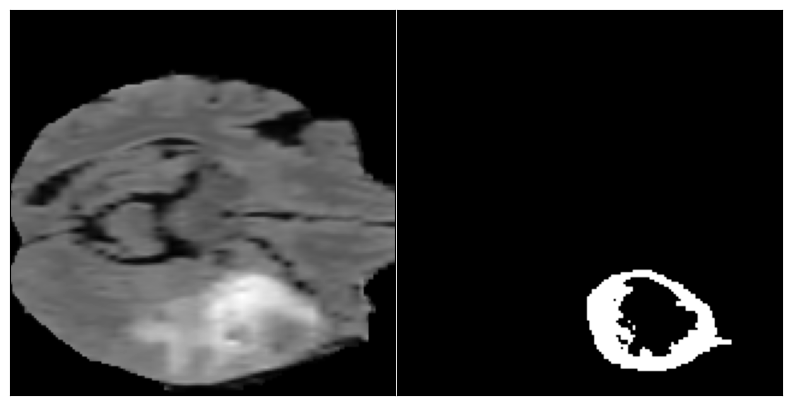

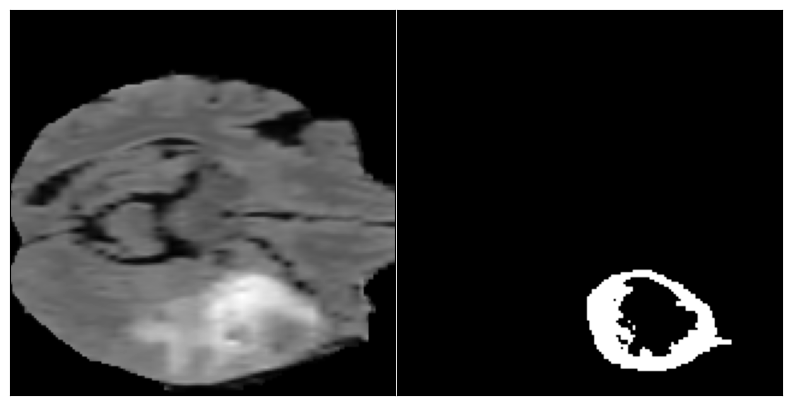

In [10]:
image, label = load_case(Data_Dir + "BRATS_001.nii.gz", Labels_Dir + "BRATS_001.nii.gz")
X, y = get_sub_volume(image, label)
util.visualize_patch(X[0, :, :, :], y[2])
X_norm = standardize(X)
util.visualize_patch(X_norm[0, :, :, :], y[2])